<a href="https://colab.research.google.com/github/Janani-R18/NM-assignments/blob/main/Assignment_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

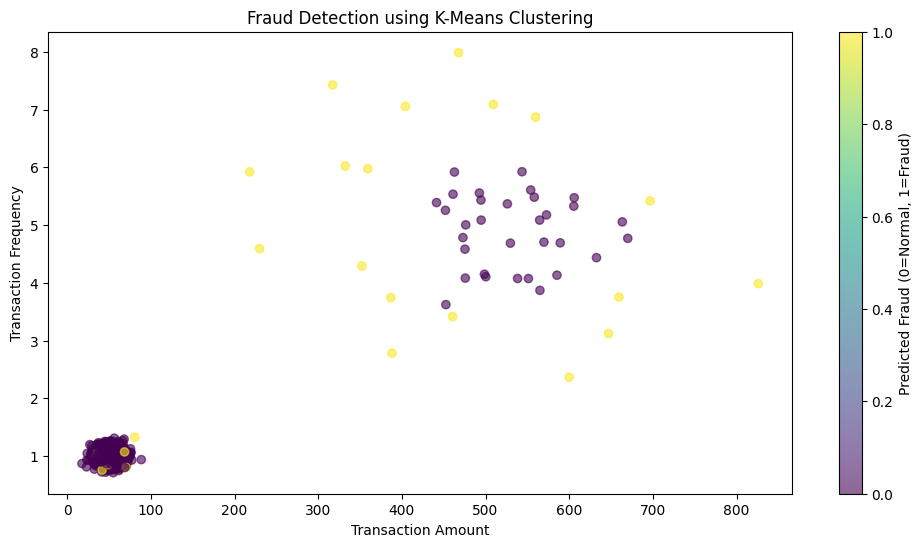

Confusion Matrix:
[[918  32]
 [ 32  18]]


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Generate synthetic transaction data (replace with real data)
np.random.seed(42)
normal_transactions = np.concatenate([
    np.random.normal(loc=50, scale=10, size=(950, 1)),  # Amount
    np.random.randint(0, 24, size=(950, 1)),  # Hour
    np.random.normal(loc=1, scale=0.1, size=(950, 1))  # Frequency
], axis=1)

fraud_transactions = np.concatenate([
    np.random.normal(loc=500, scale=100, size=(50, 1)),  # Amount
    np.random.randint(2, 5, size=(50, 1)),  # Hour (late night)
    np.random.normal(loc=5, scale=1, size=(50, 1))  # Frequency
], axis=1)

data = np.vstack([normal_transactions, fraud_transactions])
columns = ['Amount', 'Hour', 'Frequency']
df = pd.DataFrame(data, columns=columns)

# Add labels for evaluation (0=normal, 1=fraud)
df['Label'] = [0]*950 + [1]*50

# Preprocessing
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[columns])

# K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(scaled_features)
df['Cluster'] = kmeans.labels_

# Calculate distance from centroids
distances = kmeans.transform(scaled_features)
df['Distance'] = np.min(distances, axis=1)

# Detect anomalies (fraud) using distance threshold
threshold = np.percentile(df['Distance'], 95)
df['Predicted_Fraud'] = (df['Distance'] > threshold).astype(int)

# Visualization
plt.figure(figsize=(12, 6))
plt.scatter(df['Amount'], df['Frequency'],
           c=df['Predicted_Fraud'], cmap='viridis', alpha=0.6)
plt.title('Fraud Detection using K-Means Clustering')
plt.xlabel('Transaction Amount')
plt.ylabel('Transaction Frequency')
plt.colorbar(label='Predicted Fraud (0=Normal, 1=Fraud)')
plt.show()

# Evaluation
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(df['Label'], df['Predicted_Fraud'])
print("Confusion Matrix:")
print(conf_matrix)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Load and prepare data
ratings = pd.read_csv('ratings.csv')
movies = pd.read_csv('movies.csv')

# Create user-movie matrix
user_movie_matrix = ratings.pivot_table(
    index='userId',
    columns='movieId',
    values='rating'
).fillna(0)

# Normalize data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(user_movie_matrix)

# Determine optimal K using elbow method
inertia = []
K_range = range(2, 15)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

plt.plot(K_range, inertia, 'bx-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

# Train final K-means model
optimal_k = 5  # Set based on elbow plot analysis
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# Add clusters to user data
user_movie_matrix['cluster'] = clusters

def get_recommendations(user_id, num_recommendations=5):
    # Get user's cluster
    user_cluster = user_movie_matrix.loc[user_id]['cluster']

    # Find similar users in cluster
    cluster_users = user_movie_matrix[user_movie_matrix['cluster'] == user_cluster].index

    # Get top rated movies in cluster
    cluster_ratings = ratings[ratings['userId'].isin(cluster_users)]
    movie_ratings = cluster_ratings.groupby('movieId')['rating'].mean().sort_values(ascending=False)

    # Get movies user hasn't rated
    user_rated = ratings[ratings['userId'] == user_id]['movieId']
    recommendations = movie_ratings[~movie_ratings.index.isin(user_rated)]

    return recommendations.head(num_recommendations).index.tolist()

# Example usage
user_id = 42
recommended_movies = get_recommendations(user_id)
print(f"Recommended movies for user {user_id}:")
print(movies[movies['movieId'].isin(recommended_movies)]['title'])
